<a href="https://colab.research.google.com/github/Jieoi/traffic_sign/blob/main/traffic_sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the dataset

<h2>1. Data preparetion</h2>

Firstly, the dataset is obtained from [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html), the German Traffic Sign Recognition Benchmark GTSRB dataset. The file downloaded includes training images with lable, test images, and ground truth for the test images.

The path to the dataset is loaded below, the code has been modified to link to the downloaded dataset from my Google drive.

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import shutil
import os

# List of directories to be deleted
directories_to_delete = [
    '/content/clean_data'
]

# Iterate through the list of directories and delete them
for directory_to_delete in directories_to_delete:
    if os.path.exists(directory_to_delete):
        shutil.rmtree(directory_to_delete)
        print(f"Directory '{directory_to_delete}' and its contents have been deleted.")
    else:
        print(f"Directory '{directory_to_delete}' does not exist.")


Directory '/content/clean_data' does not exist.


In [3]:
import os
import sys

In [4]:
# Define the path to the getFile.py script
script_path = '/content/drive/MyDrive/final/data_preparation/getFile.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

In [5]:
# Define the path to the getFile.py script
script_path = '/content/drive/MyDrive/final/data_preparation/testGetFile.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

In [6]:
!python drive/MyDrive/final/data_preparation/testGetFile.py

.Extraction complete.
....
----------------------------------------------------------------------
Ran 5 tests in 0.007s

OK


In [7]:
# Import the extract_zip_to_directory function from getFile.py
from getFile import extract_zip_to_directory

# Define file paths
root_path = '/content/drive/MyDrive'
zip_filename = os.path.join(root_path, 'GTSRB/GTSRB.zip')
extract_dir = "/content/GTSRB"

# Call the function
extract_zip_to_directory(zip_filename, extract_dir)

Extraction complete.


In [8]:
# Assign the paths
train_directory = os.path.join(extract_dir, 'GTSRB', 'GTSRB-Training_fixed', 'GTSRB', 'Training')
ground_truth = os.path.join(extract_dir, 'GTSRB', 'GTSRB_Final_Test_GT', 'GT-final_test.csv')
test_directory = os.path.join(extract_dir, 'GTSRB', 'GTSRB_Final_Test_Images', 'GTSRB', 'Final_Test', 'Images')

print("train_directory:", train_directory)
print("ground_truth:", ground_truth)
print("test_directory:", test_directory)


train_directory: /content/GTSRB/GTSRB/GTSRB-Training_fixed/GTSRB/Training
ground_truth: /content/GTSRB/GTSRB/GTSRB_Final_Test_GT/GT-final_test.csv
test_directory: /content/GTSRB/GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images


Importing the libraries

In [9]:
import glob
import cv2
import numpy as np
import random

from concurrent.futures import ThreadPoolExecutor

import torch

import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import os
import os.path as osp
import glob
import cv2
import numpy as np
import torch
import shutil
import cv2
import matplotlib.pyplot as plt

The test images is first extracted and stored as numpy arrays:

In [10]:
# Define the path to the getFile.py script
script_path = '/content/drive/MyDrive/final/data_preparation/getData.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

import getData

In [11]:
images, labels = getData.load_and_process_training_images(train_directory)

# Now you can work with the 'images' and 'labels' variables
# For example:
print("Number of images:", len(images))
print("Number of labels:", len(labels))

Loaded 26640 images and 26640 labels in 1.3516080379486084 seconds.
Number of images: 26640
Number of labels: 26640


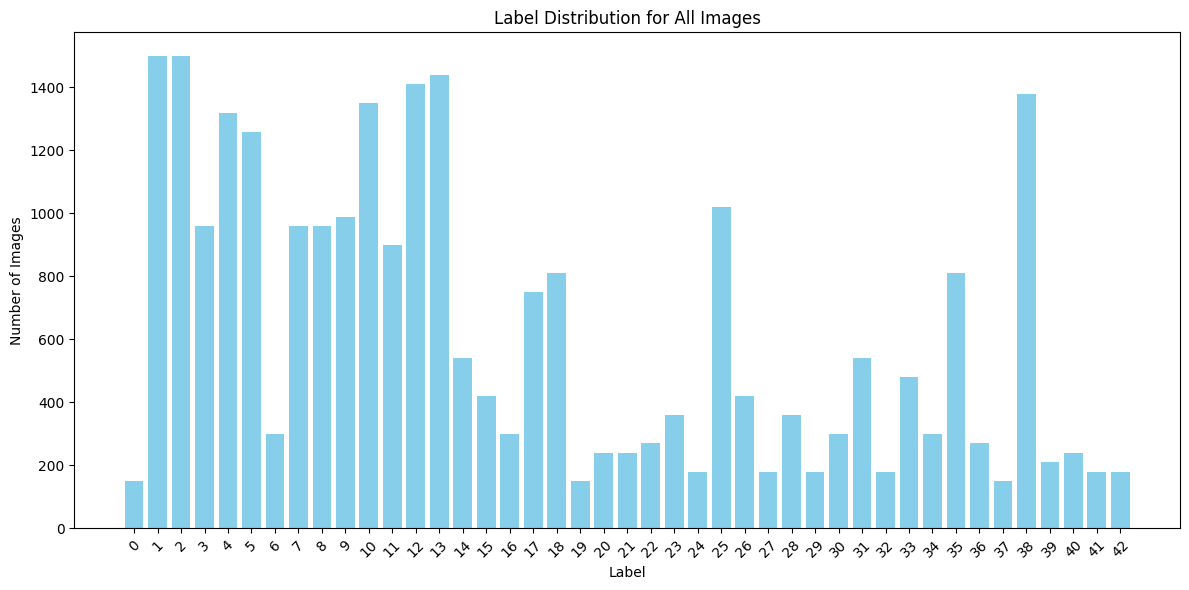

In [12]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
label_distribution = dict(zip(unique_labels, label_counts))

# Extract labels and counts from the label distribution dictionary
labels_list = list(label_distribution.keys())
counts = list(label_distribution.values())

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(labels_list, counts, tick_label=labels_list, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Label Distribution for All Images')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

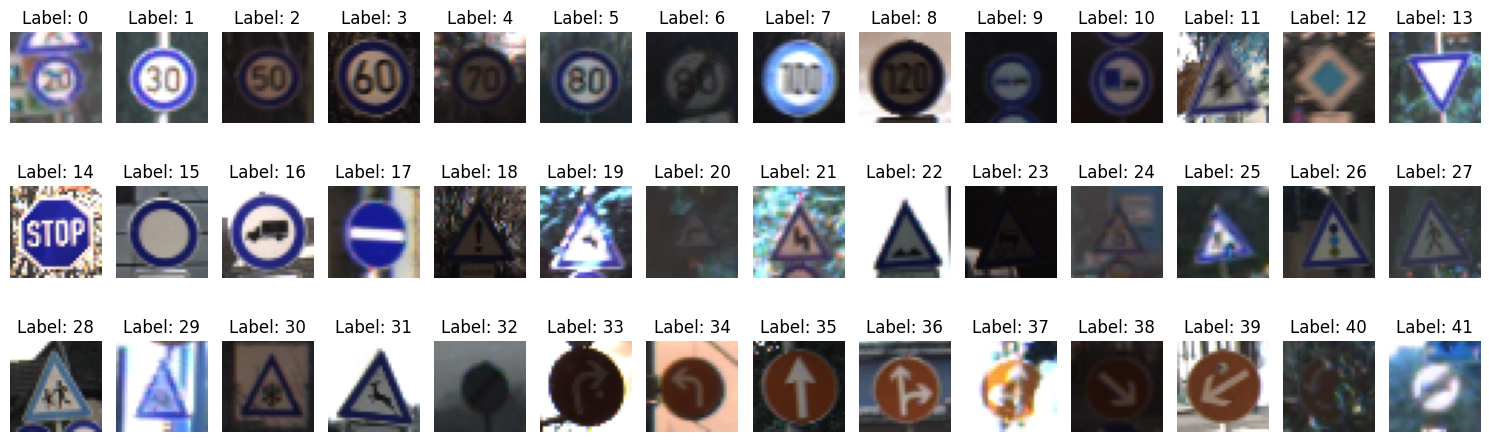

In [13]:
# Display one image from each label
num_rows = 3
num_columns = 14
num_images_to_display = num_rows * num_columns

# Create a figure with the desired number of subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    if i < len(np.unique(labels)):
        label = np.unique(labels)[i]
        label_indices = np.where(labels == label)[0]

        # Check if there are still unselected images for this label
        if label_indices.size > 0:
            random_index = label_indices[0]  # Select the first unselected image
            label_indices = label_indices[1:]  # Remove the selected image index

            ax.imshow(images[random_index])
            ax.set_title(f"Label: {label}")
            ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

Ground truth for every test file is also loaded in a pandas dataframe:

In [14]:
ground_truth_df = getData.load_ground_truth(ground_truth)
ground_truth_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000.ppm,53,54,6,5,48,49,16
1,00001.ppm,42,45,5,5,36,40,1
2,00002.ppm,48,52,6,6,43,47,38
3,00003.ppm,27,29,5,5,22,24,33
4,00004.ppm,60,57,5,5,55,52,11


Test images are extracted and stored in numpy dataframe:

In [15]:
test_images = getData.load_testing_images(test_directory)

Skipping file: /content/GTSRB/GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/GT-final_test.test.csv
Loaded 12630 test images in 0.5132136344909668 seconds.


In [16]:
!python drive/MyDrive/final/data_preparation/testGetData.py

Loaded 258 images and 258 labels in 0.010509014129638672 seconds.
..Loaded 5 test images in 0.0001780986785888672 seconds.
.
----------------------------------------------------------------------
Ran 3 tests in 0.111s

OK


 bicubic interpolation

In [17]:
# speed up for coding test
# images = images[0:2]

In [18]:
# Copy RRDBNet_arch.py and RRDB_ESRGAN_x4.pth to the /content/models directory
# Create the /content/models directory if it doesn't exist
models_directory = '/content/models'
os.makedirs(models_directory, exist_ok=True)

# Copy RRDBNet_arch.py
source_arch_path = '/content/drive/MyDrive/final/pre-trained-model/RRDBNet_arch.py'
target_arch_path = os.path.join(models_directory, 'RRDBNet_arch.py')
shutil.copy(source_arch_path, target_arch_path)

# Copy RRDB_ESRGAN_x4.pth
source_model_path = '/content/drive/MyDrive/final/pre-trained-model/RRDB_ESRGAN_x4.pth'
target_model_path = os.path.join(models_directory, 'RRDB_ESRGAN_x4.pth')
shutil.copy(source_model_path, target_model_path)


'/content/models/RRDB_ESRGAN_x4.pth'

In [19]:
# Define the path to the getFile.py script
script_path = '/content/drive/MyDrive/final/data_augmentation/processing_image.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

import processing_image

In [ ]:
# Call the upscale_images function
upscale_factor = 7
upscaled_images = processing_image.upscale_images(images, upscale_factor)

# Call the equalize_images function
equalized_images = processing_image.equalize_images(upscaled_images)

# Call the denoise_images function
denoised_images = processing_image.denoise_images(equalized_images)

# Display the original image, upscaled image, denoised image, and histogram-equalized image
plt.figure(figsize=(12, 8))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(images[26])
plt.title("Original Image")
plt.axis("off")

# Upscaled Image
plt.subplot(2, 2, 2)
plt.imshow(upscaled_images[0])
plt.title("Upscaled Image")
plt.axis("off")

# Denoised Image
plt.subplot(2, 2, 3)
plt.imshow(denoised_images[0])
plt.title("Denoised Image")
plt.axis("off")

# Equalized Image
plt.subplot(2, 2, 4)
plt.imshow(equalized_images[0])
plt.title("Equalized Image")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# save equalized images
# Define the target directory to save equalized images
equalized_output_dir = '/content/clean_data/equal'
os.makedirs(equalized_output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

# Save the equalized images to the specified directory
for idx, equalized_image in enumerate(equalized_images):
    base = f'image_{idx:05d}'  # Generate a base name using the index

    output_path = os.path.join(equalized_output_dir, f'{base}_equalized.png')
    cv2.imwrite(output_path, equalized_image)

# Display a message after saving
print(f"Equalized images saved to: {equalized_output_dir}")


In [ ]:
# Call the function with the desired inputs
img_folder = '/content/clean_data/equal/*'
output_dir = '/content/clean_data/enhanced'
model_path = '/content/drive/MyDrive/final/pre-trained-model/RRDB_ESRGAN_x4.pth'

processing_image.enhance_images_rrdb(img_folder, output_dir, model_path)

1 image_21664_equalized
2 image_13691_equalized
3 image_01861_equalized
4 image_24426_equalized
5 image_25251_equalized
6 image_24596_equalized
7 image_22354_equalized
8 image_08056_equalized
9 image_11840_equalized
10 image_24847_equalized
11 image_24888_equalized
12 image_18401_equalized
13 image_11061_equalized
14 image_05650_equalized
15 image_05586_equalized
16 image_07246_equalized
17 image_09768_equalized
18 image_07370_equalized
19 image_17905_equalized
20 image_25063_equalized
21 image_16885_equalized
22 image_19826_equalized
23 image_01359_equalized
24 image_07881_equalized
25 image_05558_equalized
26 image_22344_equalized
27 image_01687_equalized
28 image_19083_equalized
29 image_22933_equalized
30 image_04479_equalized
31 image_10852_equalized
32 image_24354_equalized
33 image_19966_equalized
34 image_11188_equalized
35 image_18589_equalized
36 image_10318_equalized
37 image_23702_equalized
38 image_17615_equalized
39 image_02931_equalized
40 image_08771_equalized
41 image_

KeyboardInterrupt: ignored

In [ ]:
!zip -r /content/file.zip /content/clean_data/enhanced

  adding: content/clean_data/enhanced/ (stored 0%)
  adding: content/clean_data/enhanced/image_10615_equalized_enhanced.png (deflated 0%)
  adding: content/clean_data/enhanced/image_05586_equalized_enhanced.png (deflated 0%)
  adding: content/clean_data/enhanced/image_06422_equalized_enhanced.png (deflated 0%)
  adding: content/clean_data/enhanced/image_18880_equalized_enhanced.png (deflated 0%)
  adding: content/clean_data/enhanced/image_04881_equalized_enhanced.png (deflated 0%)
  adding: content/clean_data/enhanced/image_23593_equalized_enhanced.png (deflated 0%)
  adding: content/clean_data/enhanced/image_09303_equalized_enhanced.png (deflated 0%)
  adding: content/clean_data/enhanced/image_16437_equalized_enhanced.png (deflated 0%)
  adding: content/clean_data/enhanced/image_15940_equalized_enhanced.png (deflated 0%)
  adding: content/clean_data/enhanced/image_08385_equalized_enhanced.png (deflated 0%)
  adding: content/clean_data/enhanced/image_00350_equalized_enhanced.png (defla

In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

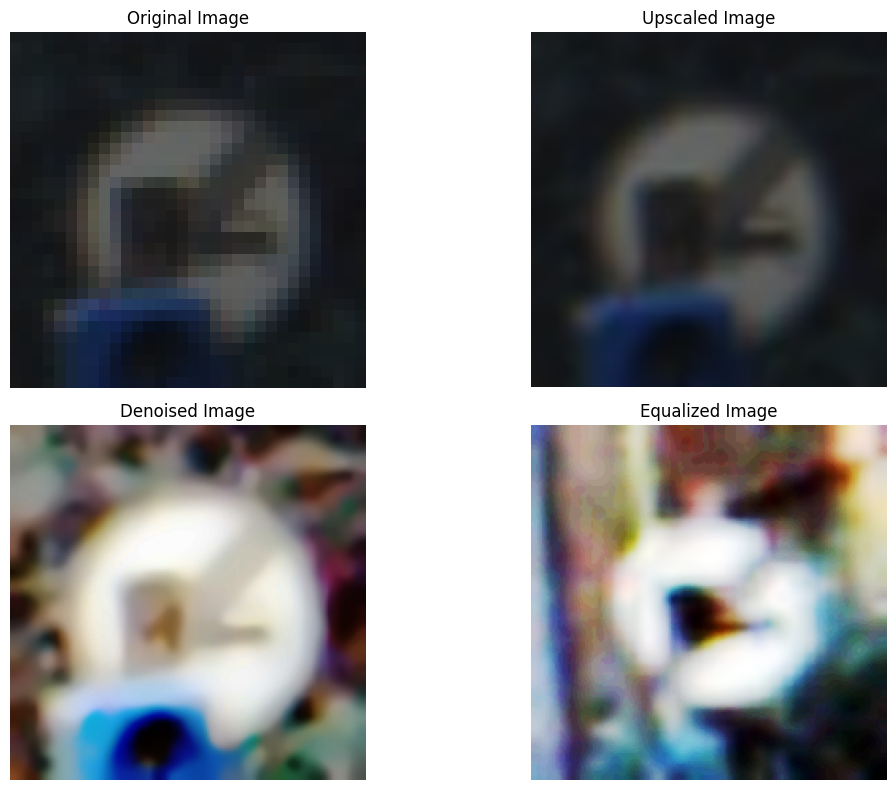

In [ ]:
# Display the original image, upscaled image, denoised image, and histogram-equalized image
plt.figure(figsize=(12, 8))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(images[25])
plt.title("Original Image")
plt.axis("off")

# Upscaled Image
plt.subplot(2, 2, 2)
plt.imshow(upscaled_images[25])
plt.title("Upscaled Image")
plt.axis("off")

# Denoised Image
plt.subplot(2, 2, 3)
plt.imshow(denoised_images[25])
plt.title("Denoised Image")
plt.axis("off")

# Equalized Image
plt.subplot(2, 2, 4)
plt.imshow(equalized_images[26])
plt.title("Equalized Image")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# deleting old equalized images
# Specify the directory to delete files from
equalized_output_dir = '/content/clean_data/equal'

# List all files in the directory
file_list = os.listdir(equalized_output_dir)

# Delete each file in the directory
for file_name in file_list:
    file_path = os.path.join(equalized_output_dir, file_name)
    os.remove(file_path)
    print(f"Deleted: {file_path}")

print("All files deleted from:", equalized_output_dir)

The lable to be predicted will be the class ids stored in the ground truth dataframe.:

In [ ]:
# Extract the class IDs from the ground_truth_df DataFrame
class_ids = ground_truth_df['ClassId'].values

# Assign X_test as the test_images array
X_test = test_images

# Assign y_test as the class_ids array
y_test = class_ids

The shape of training and testing dataset is checked:

In [ ]:
print("Training dataset:")
print("Images shape:", upscaled_images.shape)
print("Labels shape:", labels.shape)
print("="*20)
print("Testing dataset:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Print out the image for the classes

In [ ]:
len(upscaled_images)

In [ ]:
len(images)

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Get the unique class IDs
unique_classes = np.unique(labels)

# Create a subplot grid for the images
num_rows = len(unique_classes)  # One row per class
num_cols = 3  # Display 3 images per class
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4 * num_cols, 10 * num_rows))

# Iterate over the unique class IDs
for i, class_id in enumerate(unique_classes):
    # Find the indices of images in the training data belonging to the current class
    class_indices = np.where(labels == class_id)[0]

    # Randomly select 3 image indices for display
    random_indices = random.sample(list(class_indices), k=num_cols)

    # Display the class label at the top of the row
    axes[i, 0].set_title(f"Class {class_id}", fontsize=18)

    # Iterate over the random image indices
    for j, image_index in enumerate(random_indices):
        # Get the corresponding image
        image = upscaled_images_normalized[image_index]

        # Display the image
        axes[i, j].imshow(image)
        axes[i, j].axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
num_classes=43
# Split the training dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels)

In [ ]:
print("Training dataset:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

In [ ]:
# Move data to GPU
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)

In [ ]:
def plot_training_history(history):
    # Access the training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting the training and validation accuracy
    ax1.plot(training_accuracy)
    ax1.plot(validation_accuracy)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plotting the training and validation loss
    ax2.plot(training_loss)
    ax2.plot(validation_loss)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()

In [ ]:
base_model = ResNet50(include_top=False, input_shape=(32, 32, 3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))


In [ ]:
# Move model to GPU
with device:
    model = tf.keras.models.clone_model(model)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
# # Train the model on GPU
# with device:
#     epochs = 50
#     for epoch in range(epochs):
#         history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
#         if early_stopping.stopped_epoch > 0:
#             print("Early stopping at epoch", epoch)
#             break

In [ ]:
# plot_training_history(history)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained ResNet-50 model with pre-trained weights
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Freeze all layers in the base model (optional)
for layer in base_model.layers:
    layer.trainable = False

# Get the output of the last layer in the base model
x = base_model.output

# Add a global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a fully connected layer with 512 units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout layer
x = Dropout(0.5)(x)

# Add the final dense layer for the desired number of output classes
num_classes = 43  # Adjust this based on your dataset
predictions = Dense(num_classes, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# New Section

In [ ]:
# # Define early stopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model on GPU
# with tf.device('/GPU:0'):
#     epochs = 50
#     history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# print("Training completed.")

In [ ]:
# plot_training_history(history)

In [ ]:
pip install deap


In [ ]:
import random
import numpy as np
import tensorflow as tf
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load and preprocess your dataset
# X_train, X_val, y_train, y_val = train_test_split(images, labels)
# ... Data loading and preprocessing ...

# Define the evaluation function (train and evaluate the model)
def evaluate_individual(individual):
    optimizer = individual[0]
    learning_rate = individual[1]
    regularization = individual[2]
    batch_norm = individual[3]

    # Build the model architecture
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    num_classes = 43  # Adjust this based on your dataset
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with hyperparameters
    if optimizer == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    epochs = 10
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Evaluate the model and return the validation accuracy
    _, val_accuracy = model.evaluate(X_val, y_val)
    return val_accuracy,

# Create a fitness function that maximizes validation accuracy
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_optimizer", random.choice, ["adam", "rmsprop"])
toolbox.register("attr_learning_rate", random.uniform, 1e-4, 1e-2)
toolbox.register("attr_regularization", random.uniform, 1e-6, 1e-4)
toolbox.register("attr_batch_norm", random.choice, [True, False])

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_optimizer, toolbox.attr_learning_rate, toolbox.attr_regularization, toolbox.attr_batch_norm), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[0, 1, 2, 3], up=[1, 10, 10, 1], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_individual)

# Create a population of individuals
population_size = 10
population = toolbox.population(n=population_size)

# Run the genetic algorithm
generations = 10
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=generations)

# Print the best individual's hyperparameters and fitness
best_individual = tools.selBest(population, k=1)[0]
print("Best Hyperparameters:", best_individual)
print("Best Validation Accuracy:", evaluate_individual(best_individual)[0])
